# Determine optimal number of clusters

In [1]:
import os
# Set environment variables to disable multithreading
# as users will probably want to set the number of cores
# to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [2]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra import clustering
from sdss.metadata import MetaData

meta = MetaData()

# Custom functions

# Data ingestion

In [3]:
bin_id = "bin_03"
phd_dir = "/home/elom/phd"
spectra_dir = f"{phd_dir}/00_phd_code/spectra"
explanations_dir = f"{phd_dir}/00_phd_code/explanations"
paper_figures_dir = f"{phd_dir}/00_paper_explain-me-why/sections/figures/"
wave = np.load(f"{spectra_dir}/wave_spectra_imputed.npy")


# MSE
From previous analysis we determined the number of clusters is 5

In [4]:
score_name = "mse_noRel100"
explanation_run_id = "20250427190650_uniform_5000_scale"

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)


In [5]:
norm_abs_weights = np.abs(weights)
norm_abs_weights /= np.max(norm_abs_weights, axis=1, keepdims=True)

## Train clustering (KMeans)

<>:97: SyntaxWarning: invalid escape sequence '\l'
<>:98: SyntaxWarning: invalid escape sequence '\l'
<>:97: SyntaxWarning: invalid escape sequence '\l'
<>:98: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/1759297457.py:97: SyntaxWarning: invalid escape sequence '\l'
  axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_54052/1759297457.py:98: SyntaxWarning: invalid escape sequence '\l'
  axs[4,1].set_xlabel("$\lambda$ [$\AA$]")


Base size: 29, Residual size: 61
New number of segments: 129
train time: 0.05 seconds
Cluster: 0,N. spectra: 1993
Cluster: 1,N. spectra: 3704
Cluster: 2,N. spectra: 1603
Cluster: 3,N. spectra: 1759
Cluster: 4,N. spectra: 941


Text(0.5, 0, '$\\lambda$ [$\\AA$]')

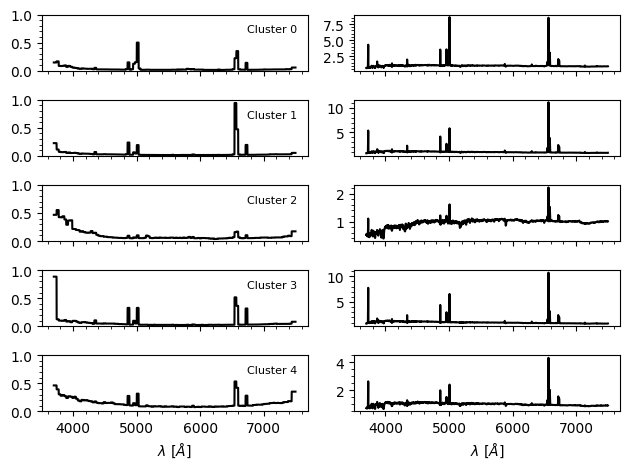

In [ ]:
X = clustering.get_weights_per_segments(
    weights=norm_abs_weights, n_segments=128,
)
# X = np.abs(X)/np.max(np.abs(X), axis=1, keepdims=True)

n_clusters = 5

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()
print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=norm_abs_weights,
    print_n_clusters=True
)

(
    _, unique_weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=X,
    print_n_clusters=False
)

# get indices of closes data points to centroids
centroids = kmeans.cluster_centers_
idx_closest_to_centroid = {}

n_closest = 9

for label, cluster in unique_weights_cluster_dict.items():

    cluster_centroid = centroids[label].reshape(1, -1)

    distances = np.sum((cluster - cluster_centroid)**2, axis=1)

    idx_closest = np.argsort(distances)[:n_closest]

    idx_closest_to_centroid[int(label)] = idx_closest

# plot average weights and spectra of each cluster

fig, axs = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_weights = cluster_weights.mean(axis=0)
    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 0].legend(
        [f"Cluster {label}"],
        fontsize=8,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 0].set_ylim(0., 1.)

    axs[label, 1].plot(
        wave, avg_spectrum,
        color="black",
    )

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
axs[4,1].set_xlabel("$\lambda$ [$\AA$]")
# axs[0].set_ylim(0., 1.)

### Cluster 0

Cluster label: 0
Cluster centroid index: [ 941 1326  543   76 1598 1558  744 1057  616]


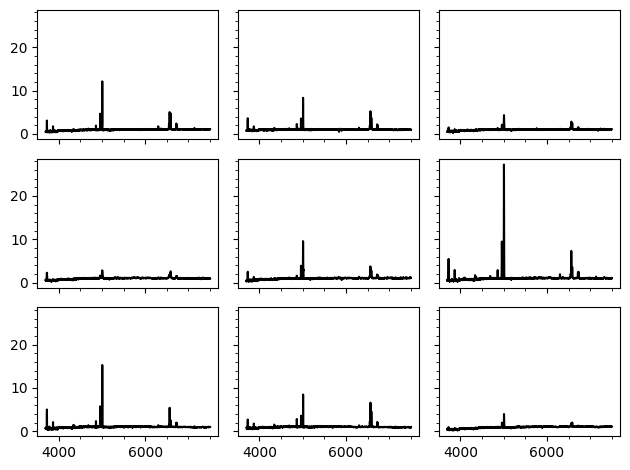

In [13]:
label = 0
centroid_indexes = idx_closest_to_centroid[label]

print(
    f"Cluster label: {label}\n"
    f"Cluster centroid index: {centroid_indexes}"
)

fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=None,
    sharex=True,
    sharey=True,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

# plot spectra and explanation weights of centroid

for i, centroid_index in enumerate(centroid_indexes):

    spectrum = spectra_cluster_dict[label][centroid_index]
    axs[i//3, i%3].plot(wave, spectrum, color="black")

    # weights_close = weights_cluster_dict[label][centroid_index]
    # axs[1].plot(wave, weights_close, color="black")

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
# axs[1].set_xlabel("$\lambda$ [\AA]")
# axs[1].set_ylim(0., 1.)


### cluster 1

Cluster label: 1
Cluster centroid index: [ 344 2594 1926  205 2729 1005 2117 2145  193]


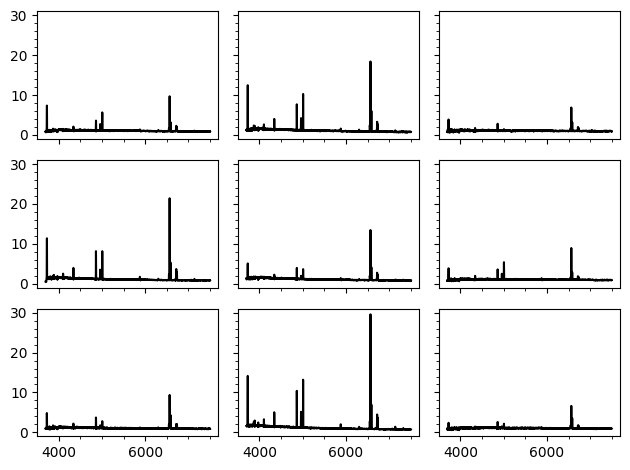

In [14]:
label = 1
centroid_indexes = idx_closest_to_centroid[label]

print(
    f"Cluster label: {label}\n"
    f"Cluster centroid index: {centroid_indexes}"
)

fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=None,
    sharex=True,
    sharey=True,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

# plot spectra and explanation weights of centroid

for i, centroid_index in enumerate(centroid_indexes):

    spectrum = spectra_cluster_dict[label][centroid_index]
    axs[i//3, i%3].plot(wave, spectrum, color="black")

    # weights_close = weights_cluster_dict[label][centroid_index]
    # axs[1].plot(wave, weights_close, color="black")

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
# axs[1].set_xlabel("$\lambda$ [\AA]")
# axs[1].set_ylim(0., 1.)


### Cluster 2

Cluster label: 2
Cluster centroid index: [1047 1541 1518 1370  237  817  652  632  122]


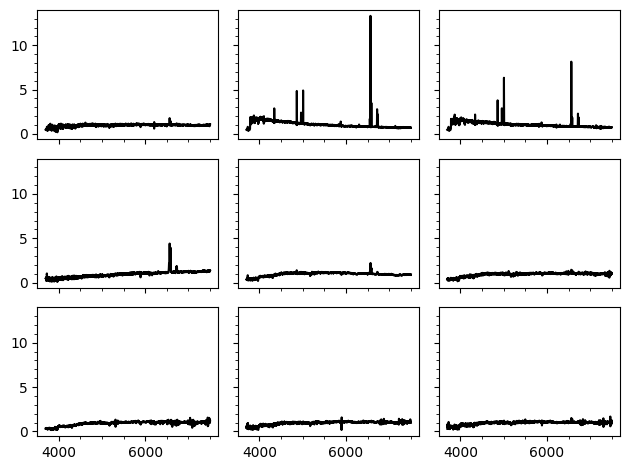

In [15]:
label = 2
centroid_indexes = idx_closest_to_centroid[label]

print(
    f"Cluster label: {label}\n"
    f"Cluster centroid index: {centroid_indexes}"
)

fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=None,
    sharex=True,
    sharey=True,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

# plot spectra and explanation weights of centroid

for i, centroid_index in enumerate(centroid_indexes):

    spectrum = spectra_cluster_dict[label][centroid_index]
    axs[i//3, i%3].plot(wave, spectrum, color="black")

    # weights_close = weights_cluster_dict[label][centroid_index]
    # axs[1].plot(wave, weights_close, color="black")

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
# axs[1].set_xlabel("$\lambda$ [\AA]")
# axs[1].set_ylim(0., 1.)


### Cluster 3

Cluster label: 3
Cluster centroid index: [1592 1229 1346  411 1272  373 1365 1595  868]


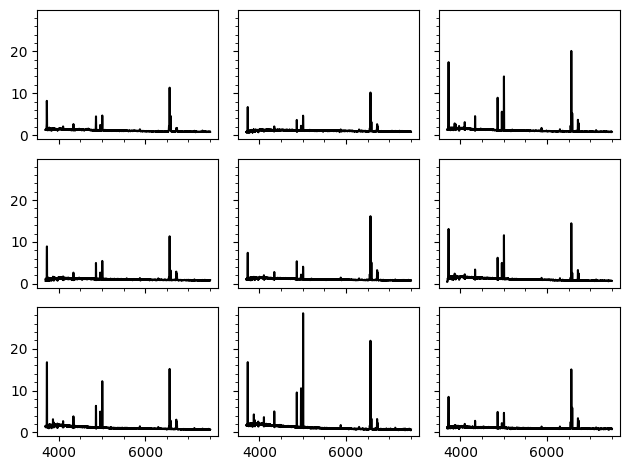

In [16]:
label = 3
centroid_indexes = idx_closest_to_centroid[label]

print(
    f"Cluster label: {label}\n"
    f"Cluster centroid index: {centroid_indexes}"
)

fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=None,
    sharex=True,
    sharey=True,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

# plot spectra and explanation weights of centroid

for i, centroid_index in enumerate(centroid_indexes):

    spectrum = spectra_cluster_dict[label][centroid_index]
    axs[i//3, i%3].plot(wave, spectrum, color="black")

    # weights_close = weights_cluster_dict[label][centroid_index]
    # axs[1].plot(wave, weights_close, color="black")

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
# axs[1].set_xlabel("$\lambda$ [\AA]")
# axs[1].set_ylim(0., 1.)


### Cluster 4

Cluster label: 4
Cluster centroid index: [693 184 147  72 775 502 156 375 514]


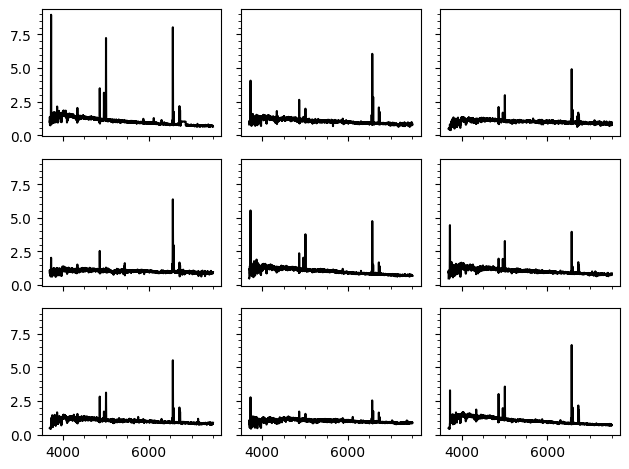

In [17]:
label = 4
centroid_indexes = idx_closest_to_centroid[label]

print(
    f"Cluster label: {label}\n"
    f"Cluster centroid index: {centroid_indexes}"
)

fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=None,
    sharex=True,
    sharey=True,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

# plot spectra and explanation weights of centroid

for i, centroid_index in enumerate(centroid_indexes):

    spectrum = spectra_cluster_dict[label][centroid_index]
    axs[i//3, i%3].plot(wave, spectrum, color="black")

    # weights_close = weights_cluster_dict[label][centroid_index]
    # axs[1].plot(wave, weights_close, color="black")

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
# axs[1].set_xlabel("$\lambda$ [\AA]")
# axs[1].set_ylim(0., 1.)


## Cluster all explanation weights

<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:67: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:67: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/348034174.py:66: SyntaxWarning: invalid escape sequence '\l'
  axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_54052/348034174.py:67: SyntaxWarning: invalid escape sequence '\l'
  axs[4,1].set_xlabel("$\lambda$ [$\AA$]")


train time: 0.85 seconds
Cluster: 0,N. spectra: 1760
Cluster: 1,N. spectra: 4168
Cluster: 2,N. spectra: 1926
Cluster: 3,N. spectra: 1336
Cluster: 4,N. spectra: 810


Text(0.5, 0.98, 'Mean spectra and explanation weights (mse_noRel100)')

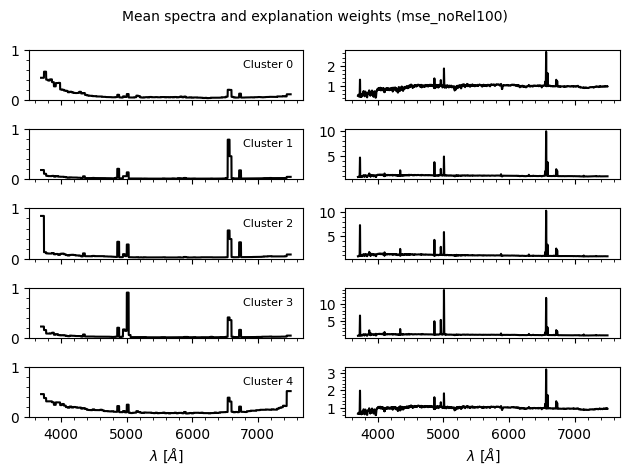

In [55]:
X = norm_abs_weights

n_clusters = 5

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()

print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=X,
    print_n_clusters=True
)

# plot average weights and spectra of each cluster

fig, axs = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid

for label, cluster_weights in weights_cluster_dict.items():

    avg_weights = cluster_weights.mean(axis=0)
    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, avg_weights,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 0].legend(
        [f"Cluster {label}"],
        fontsize=8,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 0].set_ylim(0., 1.)

    axs[label, 1].plot(
        wave, avg_spectrum,
        color="black",
    )

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
axs[4,1].set_xlabel("$\lambda$ [$\AA$]")
fig.suptitle(
    "Mean spectra and explanation weights "
    f"({score_name})",
    fontsize=10,
    # y=0.95
)
# axs[0].set_ylim(0., 1.)

### Plot centroids

<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:67: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:67: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/524938870.py:66: SyntaxWarning: invalid escape sequence '\l'
  axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_54052/524938870.py:67: SyntaxWarning: invalid escape sequence '\l'
  axs[4,1].set_xlabel("$\lambda$ [$\AA$]")


train time: 0.91 seconds
Cluster: 0,N. spectra: 1760
Cluster: 1,N. spectra: 4168
Cluster: 2,N. spectra: 1926
Cluster: 3,N. spectra: 1336
Cluster: 4,N. spectra: 810


Text(0.5, 0.98, 'Mean spectra and weights centroids (mse_noRel100)')

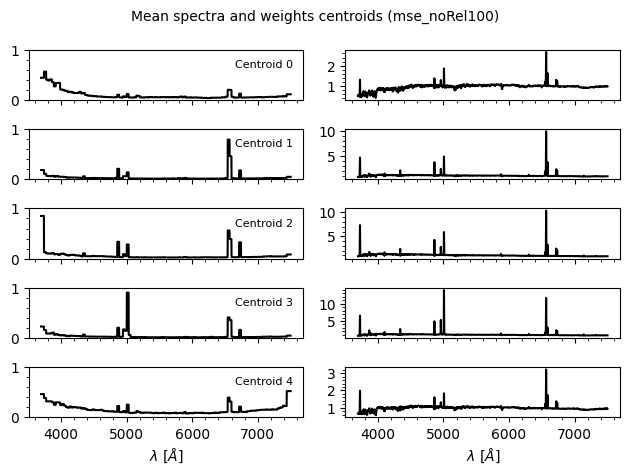

In [57]:
X = norm_abs_weights

n_clusters = 5

start_time = time.perf_counter()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
end_time = time.perf_counter()

print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=anomalies_array,
    weights=X,
    print_n_clusters=True
)

# plot average weights and spectra of each cluster

fig, axs = plt.subplots(
    nrows=5,
    ncols=2,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

#  weights of centroid
centroids_all = kmeans.cluster_centers_

for label, centroid in enumerate(centroids_all):

    avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

    axs[label, 0].plot(
        wave, centroid,
        color="black",
        label=f"Cluster {label}"
    )

    axs[label, 0].legend(
        [f"Centroid {label}"],
        fontsize=8,
        handlelength=0, handletextpad=0,
        loc="upper right",
        frameon=False
    )

    axs[label, 0].set_ylim(0., 1.)

    axs[label, 1].plot(
        wave, avg_spectrum,
        color="black",
    )

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
axs[4,0].set_xlabel("$\lambda$ [$\AA$]")
axs[4,1].set_xlabel("$\lambda$ [$\AA$]")
fig.suptitle(
    "Mean spectra and weights centroids "
    f"({score_name})",
    fontsize=10,
    # y=0.95
)
# axs[0].set_ylim(0., 1.)

In [56]:
kmeans.cluster_centers_.shape

(5, 3773)

#### Average spectra of cluster 0

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/388430813.py:22: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [\AA]")


Text(0.5, 0, '$\\lambda$ [\\AA]')

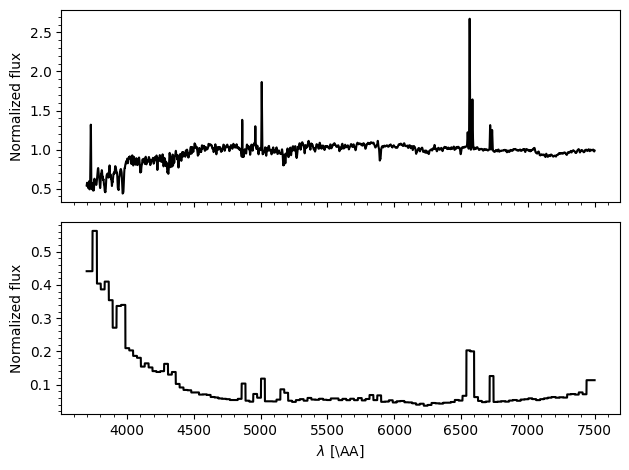

In [31]:
label = 0
centroid = kmeans.cluster_centers_[label]
avg_spectrum = np.mean(spectra_cluster_dict[label], axis=0)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

axs[0].plot(wave, avg_spectrum, color="black")
axs[0].set_ylabel("Normalized flux")
# axs[0].set_xlabel("$\lambda$ [\AA]")
axs[1].plot(wave, centroid, color="black")
axs[1].set_ylabel("Normalized flux")
axs[1].set_xlabel("$\lambda$ [\AA]")


#### Average spectra of cluster 1

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/2157794956.py:22: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [\AA]")


Text(0.5, 0, '$\\lambda$ [\\AA]')

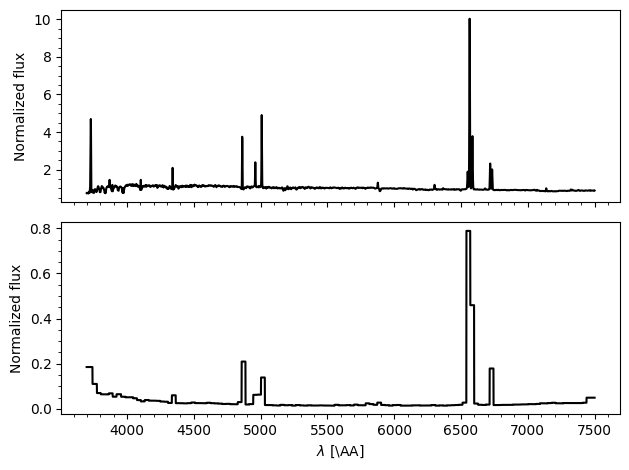

In [35]:
label = 1
centroid = kmeans.cluster_centers_[label]
avg_spectrum = np.mean(spectra_cluster_dict[label], axis=0)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

axs[0].plot(wave, avg_spectrum, color="black")
axs[0].set_ylabel("Normalized flux")
# axs[0].set_xlabel("$\lambda$ [\AA]")
axs[1].plot(wave, centroid, color="black")
axs[1].set_ylabel("Normalized flux")
axs[1].set_xlabel("$\lambda$ [\AA]")


#### Average spectra of cluster 2

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/3325888968.py:22: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [\AA]")


Text(0.5, 0, '$\\lambda$ [\\AA]')

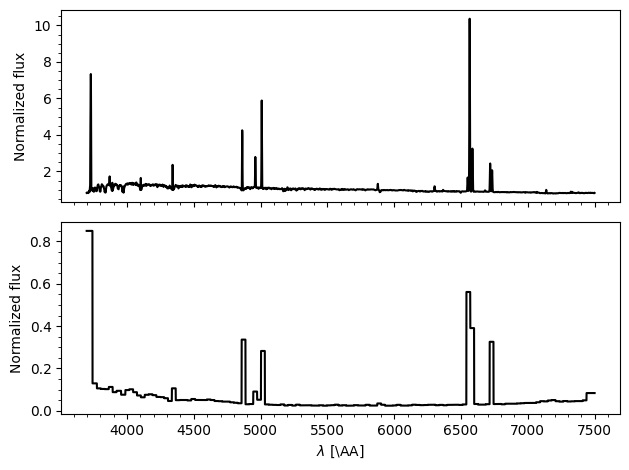

In [34]:
label = 2
centroid = kmeans.cluster_centers_[label]
avg_spectrum = np.mean(spectra_cluster_dict[label], axis=0)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

axs[0].plot(wave, avg_spectrum, color="black")
axs[0].set_ylabel("Normalized flux")
# axs[0].set_xlabel("$\lambda$ [\AA]")
axs[1].plot(wave, centroid, color="black")
axs[1].set_ylabel("Normalized flux")
axs[1].set_xlabel("$\lambda$ [\AA]")


#### Average spectra of cluster 3

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/2392232934.py:22: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [\AA]")


Text(0.5, 0, '$\\lambda$ [\\AA]')

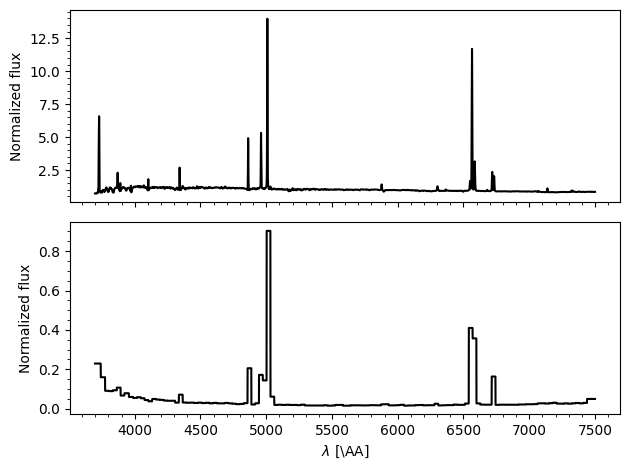

In [33]:
label = 3
centroid = kmeans.cluster_centers_[label]
avg_spectrum = np.mean(spectra_cluster_dict[label], axis=0)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

axs[0].plot(wave, avg_spectrum, color="black")
axs[0].set_ylabel("Normalized flux")
# axs[0].set_xlabel("$\lambda$ [\AA]")
axs[1].plot(wave, centroid, color="black")
axs[1].set_ylabel("Normalized flux")
axs[1].set_xlabel("$\lambda$ [\AA]")


#### Average spectra of cluster 4


<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_54052/2716707447.py:22: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [\AA]")


Text(0.5, 0, '$\\lambda$ [\\AA]')

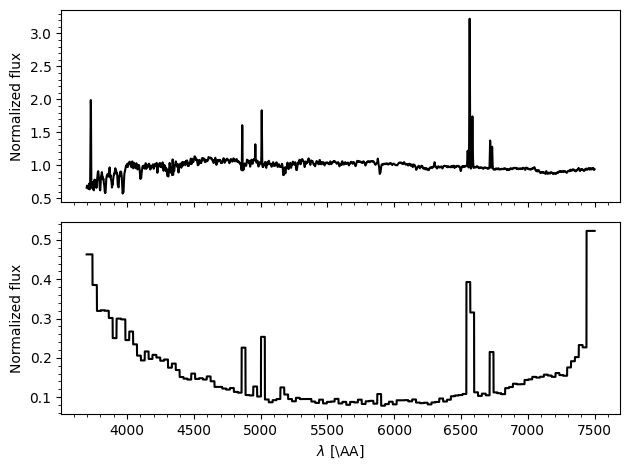

In [32]:
label = 4
centroid = kmeans.cluster_centers_[label]
avg_spectrum = np.mean(spectra_cluster_dict[label], axis=0)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=None,
    sharex=True,
    sharey=False,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

axs[0].plot(wave, avg_spectrum, color="black")
axs[0].set_ylabel("Normalized flux")
# axs[0].set_xlabel("$\lambda$ [\AA]")
axs[1].plot(wave, centroid, color="black")
axs[1].set_ylabel("Normalized flux")
axs[1].set_xlabel("$\lambda$ [\AA]")


### Cluster 0

Cluster label: 0
Cluster centroid index: [1124 1693 1667 1496  393  184 1712  620  878]


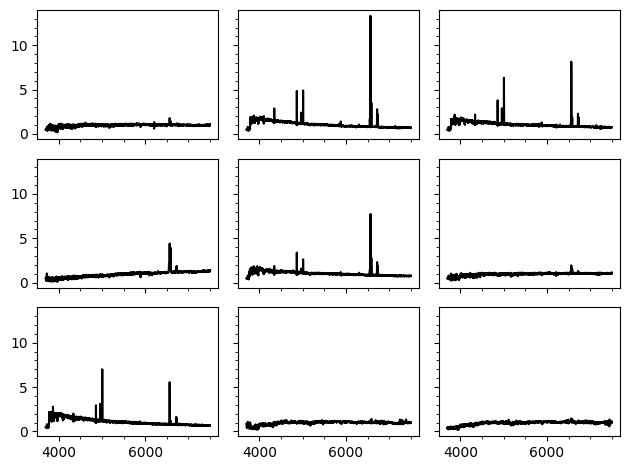

In [24]:
label = 0
centroid_indexes = idx_closest_to_centroid[label]

print(
    f"Cluster label: {label}\n"
    f"Cluster centroid index: {centroid_indexes}"
)

fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=None,
    sharex=True,
    sharey=True,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

# plot spectra and explanation weights of centroid

for i, centroid_index in enumerate(centroid_indexes):

    spectrum = spectra_cluster_dict[label][centroid_index]
    axs[i//3, i%3].plot(wave, spectrum, color="black")

    # weights_close = weights_cluster_dict[label][centroid_index]
    # axs[1].plot(wave, weights_close, color="black")

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
# axs[1].set_xlabel("$\lambda$ [\AA]")
# axs[1].set_ylim(0., 1.)


### Cluster 1

Cluster label: 1
Cluster centroid index: [ 215  204  359 2908 1064 2753  559 2031 1371]


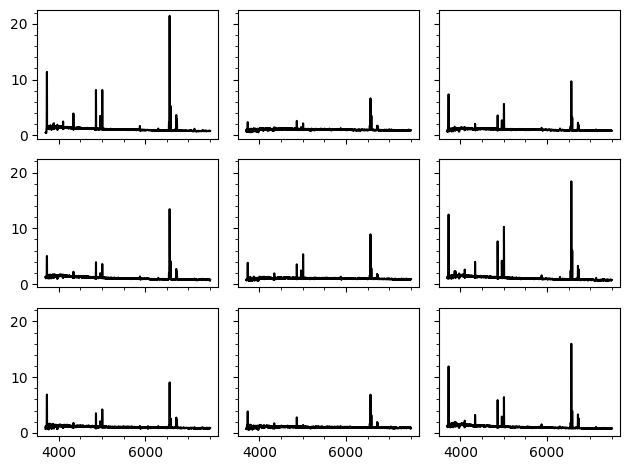

In [25]:
label = 1
centroid_indexes = idx_closest_to_centroid[label]

print(
    f"Cluster label: {label}\n"
    f"Cluster centroid index: {centroid_indexes}"
)

fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=None,
    sharex=True,
    sharey=True,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

# plot spectra and explanation weights of centroid

for i, centroid_index in enumerate(centroid_indexes):

    spectrum = spectra_cluster_dict[label][centroid_index]
    axs[i//3, i%3].plot(wave, spectrum, color="black")

    # weights_close = weights_cluster_dict[label][centroid_index]
    # axs[1].plot(wave, weights_close, color="black")

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
# axs[1].set_xlabel("$\lambda$ [\AA]")
# axs[1].set_ylim(0., 1.)


### Cluster 2

Cluster label: 2
Cluster centroid index: [1382 1756 1821  484 1515  389  343 1861  582]


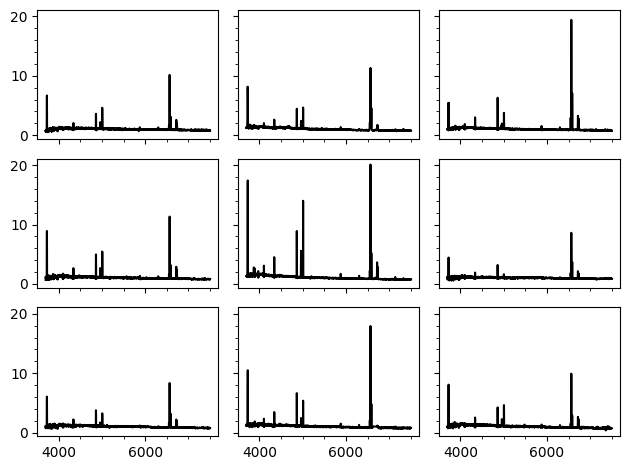

In [26]:
label = 2
centroid_indexes = idx_closest_to_centroid[label]

print(
    f"Cluster label: {label}\n"
    f"Cluster centroid index: {centroid_indexes}"
)

fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=None,
    sharex=True,
    sharey=True,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

# plot spectra and explanation weights of centroid

for i, centroid_index in enumerate(centroid_indexes):

    spectrum = spectra_cluster_dict[label][centroid_index]
    axs[i//3, i%3].plot(wave, spectrum, color="black")

    # weights_close = weights_cluster_dict[label][centroid_index]
    # axs[1].plot(wave, weights_close, color="black")

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
# axs[1].set_xlabel("$\lambda$ [\AA]")
# axs[1].set_ylim(0., 1.)


### Cluster 3

Cluster label: 3
Cluster centroid index: [483 162 617 890 553 768 871 388 470]


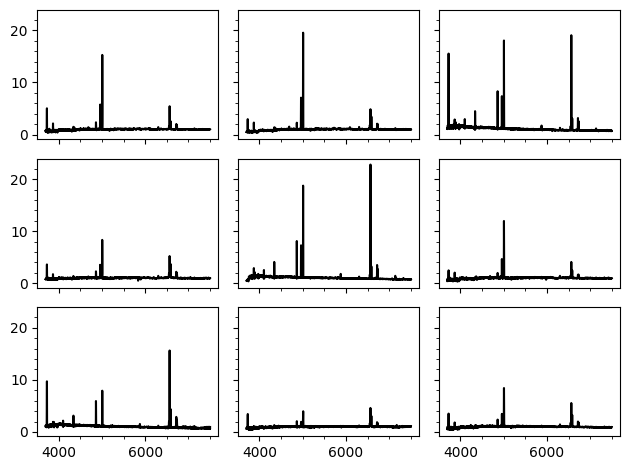

In [27]:
label = 3
centroid_indexes = idx_closest_to_centroid[label]

print(
    f"Cluster label: {label}\n"
    f"Cluster centroid index: {centroid_indexes}"
)

fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=None,
    sharex=True,
    sharey=True,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

# plot spectra and explanation weights of centroid

for i, centroid_index in enumerate(centroid_indexes):

    spectrum = spectra_cluster_dict[label][centroid_index]
    axs[i//3, i%3].plot(wave, spectrum, color="black")

    # weights_close = weights_cluster_dict[label][centroid_index]
    # axs[1].plot(wave, weights_close, color="black")

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
# axs[1].set_xlabel("$\lambda$ [\AA]")
# axs[1].set_ylim(0., 1.)


### Cluster 4

Cluster label: 4
Cluster centroid index: [646 746 486 569 640 561 630 691 655]


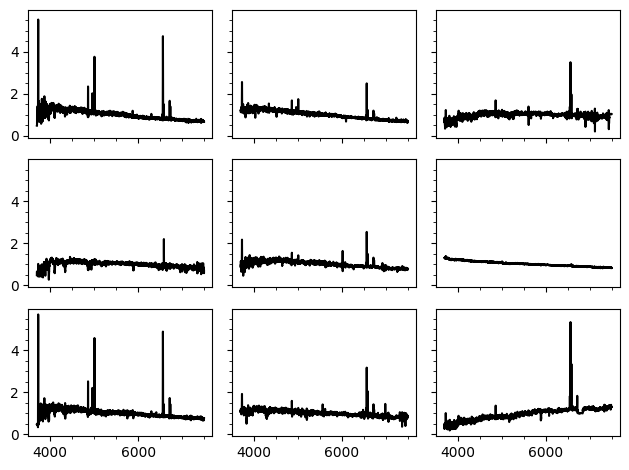

In [28]:
label = 4
centroid_indexes = idx_closest_to_centroid[label]

print(
    f"Cluster label: {label}\n"
    f"Cluster centroid index: {centroid_indexes}"
)

fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=None,
    sharex=True,
    sharey=True,
    tight_layout=True,
)

# set minor ticks on
for ax in axs.flatten(): ax.minorticks_on()

# plot spectra and explanation weights of centroid

for i, centroid_index in enumerate(centroid_indexes):

    spectrum = spectra_cluster_dict[label][centroid_index]
    axs[i//3, i%3].plot(wave, spectrum, color="black")

    # weights_close = weights_cluster_dict[label][centroid_index]
    # axs[1].plot(wave, weights_close, color="black")

# axs[0].set_ylabel("Normalized flux")
# axs[1].set_ylabel("Explanation weights")
# axs[1].set_xlabel("$\lambda$ [\AA]")
# axs[1].set_ylim(0., 1.)


# MSE noRel 97

In [7]:
score_name = "mse_noRel97"
explanation_run_id = "20250427151754_uniform_5000_scale"

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)


# MSE filter 250 kms noRel100

In [20]:
score_name = "mse_filter_250kms_noRel100"
explanation_run_id = "20250427094150_uniform_5000_scale"

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)

# MSE filter 250 kms noRel97

In [11]:
score_name = "mse_filter_250kms_noRel97"
explanation_run_id = "20250427105355_uniform_5000_scale"

weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
)